In [1]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
import os
os.environ.setdefault("HF_HOME", "/data/mjh24/hf")
os.environ.setdefault("TRANSFORMERS_CACHE", "/data/mjh24/hf/transformers")
os.makedirs(os.environ["TRANSFORMERS_CACHE"], exist_ok=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.txtGraphPruning.graph_clustering import leiden_clustering, mini_graphs_from_clusters, louvain_clustering
from Stage2.classifyingEdges.classifyingFLANT5 import clean_instructional_text, classify_link_pairs_flan_batched
from Stage2.classifyingEdges.classifyingDeBerta import classify_node_isSentence, classify_node_isCatgory
from Stage2.classifyingEdges.rewritingOPENAI import add_context, summairse, summairse_clusters
from Stage2.classifyingEdges.classifyingOpenAI import classify_needsContext_openAI, classify_link_pairs_openAI, classify_pairwiseEdges_openAI
from Stage2.classifyingEdges.metrics import metrics
from itertools import combinations
from collections import defaultdict
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'infomap', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


### Step 1. ###
Load the model and download the website

In [2]:
# Load model
# model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
# state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model = GraphAttentionNetwork(in_dim = 119, pe_dim=11, edge_in_dim = 210, edge_emb_dim = 32, heads = 4)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/TrueTransformer-newtagsnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
#htmlFile = "/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0000.htm"
url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
# url = "https://westinghousenuclear.com/"
# url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
# url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
# url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
downloadHTML(url,1,htmlFile)

Saved https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024 → /vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html
Page limit hit


### Step 2. ###
Apply the graph model to extract all the possible edges.
This extracts all text nodes found and outputs all possible edges, along with their probabilities

In [3]:
# Get label edges from text nodes in the website
#sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, alreadyConvertedToGraph="/vol/bitbucket/mjh24/IAEA-thesis/data/0000_test", remove_dupes=REMOVE_DUPES)
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted, title_label, title_txt, title_xpaths, title_probs = txtExtractor(htmlFile, model, remove_dupes=REMOVE_DUPES)
model.to("cpu")         # offload to CPU
if torch.cuda.is_available():
    torch.cuda.empty_cache() # reclaim GPU cache

In [4]:
for i in range(len(title_txt)):
    print(title_txt[i], title_probs[i])

Nuclear Politics 0.99988616
Estonia’s Parliament Resolution Paves Way For Establishing Nuclear Energy Legislation 0.999851
Resolution 0.9997658
Law 0.9994918
New Build
                  
                      
                        
                        
                      
                    Russia And Turkey Test Innovative Solution For Financing Of Akkuyu Nuclear Station 0.9992054
Parliament 0.9991714
Regulator 0.99857247
Country takes step closer to setting up a regulatory authority 0.9985398
Analysis 0.9981869
Fermi Energia continues to prepare the application for the national designated spatial planning and various works for procurement preparation, training and recruitment of necessary personnel and cooperation with communities, the spokesperson said. 0.99815136
A spokesperson for Fermi Energia told NucNet in an email that the company welcomes the parliament’s resolution but “there is a lot of work ahead”. 0.99803954
World Nuclear Map 0.9977512
Focus 0.9972543
Infograph

In [5]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, ",:\\-.%'\\s", lower=False), normalise_text(b, ",:\\-.%'\\s", lower=False)])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)

Extract unique nodes from the edges and create a mapping from node to edge

In [6]:
node_unique_label_index, node_to_edge_pos = np.unique(sorted_label_index, return_index=True)
node_to_edge_pos = np.array([[int(idx/2),0] if idx%2==0 else [int(idx/2),1] for idx in node_to_edge_pos])
node_to_edge_x_pos, node_to_edge_y_pos = node_to_edge_pos[:,0], node_to_edge_pos[:,1]

node_unique_txts, node_unique_xpaths = txts[node_to_edge_x_pos,node_to_edge_y_pos], xpaths[node_to_edge_x_pos, node_to_edge_y_pos]

### Step 3. ###
This filters out all the nodes where the text is a button/navigational link.

This uses a FLAN-T5 model

In [7]:
# Remove all html instructional labels
txtsShortened = [[a.split(".")[0], b.split(".")[0]] for a, b in txts]
isButton, buttonTxt = clean_instructional_text(txtsShortened, batch_size=16)
opmask = np.array(isButton, dtype=bool)
mask = np.logical_not(opmask)

print("All the nodes filtered out:\n\n")
isButtonNode = np.zeros_like(node_unique_txts, dtype=bool)
for key, value in buttonTxt.items():
    if value == 1:
        idx = np.where(node_unique_txts==key)
        print(len(idx[0]),"-",key)
        isButtonNode[idx] = True

All the nodes filtered out:


1 - Load more
1 - Join NucNet


In [8]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
node_unique_label_index, node_to_edge_pos, node_unique_txts, node_unique_xpaths = node_unique_label_index[~isButtonNode], node_to_edge_pos[~isButtonNode], node_unique_txts[~isButtonNode], node_unique_xpaths[~isButtonNode]

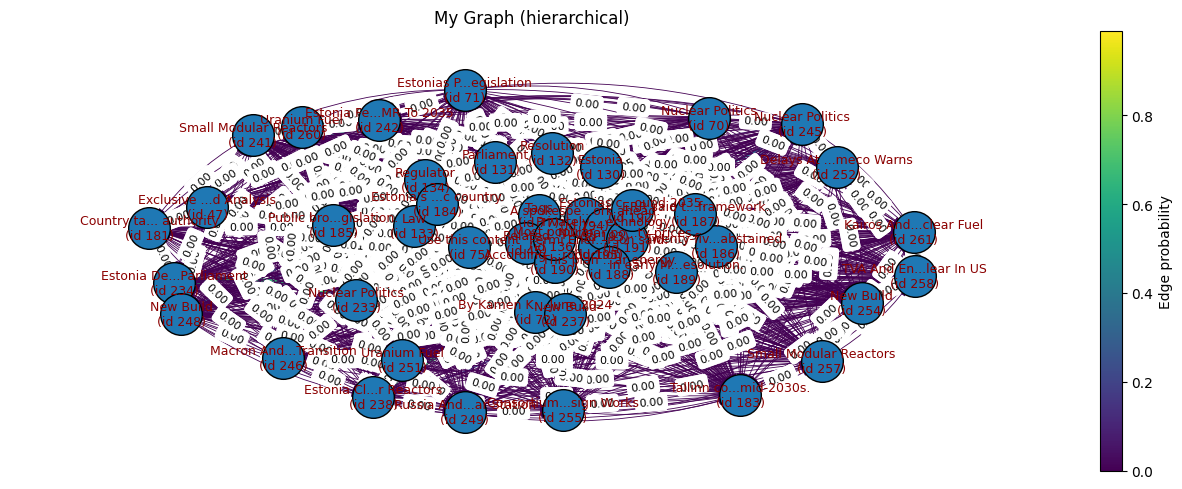

In [9]:
# Displaying the graph before all the pruning steps
_=draw_graph_from_arrays(
    txt_edge_pairs=txts,
    id_edge_pairs=sorted_label_index,
    xpath_edge_pairs=xpaths,
    probs=probs,
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(12, 5),
    title="My Graph (hierarchical)",
)

### Step 4. ###
This filters out all the low probability edges using the finding from the probability paper. At least two edges per node are saved

In [ ]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.1, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = np.array(mask, dtype=bool) 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
print("Edges filtered out: ", [print(edge) for edge in txts[~mask]])
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

1980  ->  157
['Tags' 'Use this content']
['According to ERR, supporters of the resolution argue that nuclear power will complement renewable energy sources by providing a stable, continuous generation capacity, thereby reducing the variability in energy production.'
 'Tags']
['Estonias climate strategy includes plans for up to four small modular reactors with the first to be operational around 2035.'
 'Tags']
['Twenty-five members of parliament voted against the resolution and two abstained.'
 'Fermi Energia continues to prepare the application for the national designated spatial planning and various works for procurement preparation, training and recruitment of necessary personnel and cooperation with communities, the spokesperson said.']
['In early May, 55 members of Estonian parliament submitted the draft nuclear energy resolution.'
 "Nuclear power is also expected to play a role in achieving Estonia's climate targets, securing long-term energy supply, and stabilising electricity p

### Step 5. ###
This filters out all the edges where the two text nodes make no sense together (i.e. they talk about different things)

In [317]:
# Classify the edges
#classificationDeBerta, scoresDeberta = classify_link_pairs_zero_shot(txts, batch_size=64, confidence_Factor=0.9, return_scores=True)
#classificationDeBerta_twostep = classify_link_pairs_zero_shot_two_step(txts, batch_size=64, return_scores=False)
classificationFlan = classify_link_pairs_flan_batched(txts, batch_size=32)
#classificationOpenAI = classify_link_pairs_openAI(txts[:40])
#print(classificationDeBerta)
#print(classificationFlan)
#print(classificationDeBerta_twostep)
#print(classificationOpenAI)


In [318]:
#Quick informal test
# y_true_str = "2 2 1 1 ? ? ? ? 3 3 1 1 3 3 2 2 2 2 1 1 ? ? 1 1 3 3 1 1 3 3 1 1 1 1 2 2 2 2 2 2"
# #classificationOpenAI = [1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1]
# y_true = [3 if tok == "?" else int(tok) for tok in y_true_str.split()]

In [319]:
#metrics(classificationDeBerta[:len(y_true)], y_true)
#metrics(classificationFlan[:len(y_true)], y_true)
#metrics(classificationDeBerta_twostep[:len(y_true)], y_true)
#metrics(classificationOpenAI[:len(y_true)], y_true)

In [349]:
# if len(classificationFlan) != len(txts):
#     raise Exception("The classification is not the same length as the number of edges")
# for (pair, lab) in zip(txts, classificationFlan):
#         print(lab, pair)

#for (pair, lab, sc) in zip(txts, classificationDeBerta, scoresDeberta or []):
#        print(lab, pair, "| scores:", {k: round(v, 3) for k, v in sc.items()})

In [321]:
mask = np.array([(False if i==3 else True) for i in classificationFlan])
print("Removing the following edges:\n\n", txts[~mask])
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

Removing the following edges:

 [['Most popular'
  'According to ERR, supporters of the resolution argue that nuclear power will complement renewable energy sources by providing a stable, continuous generation capacity, thereby reducing the variability in energy production.']
 ['According to ERR, supporters of the resolution argue that nuclear power will complement renewable energy sources by providing a stable, continuous generation capacity, thereby reducing the variability in energy production.'
  'Most popular']
 ['Most popular'
  "Nuclear power is also expected to play a role in achieving Estonia's climate targets, securing long-term energy supply, and stabilising electricity prices."]
 ["Nuclear power is also expected to play a role in achieving Estonia's climate targets, securing long-term energy supply, and stabilising electricity prices."
  'Most popular']
 ['Most popular'
  'Privately-owned Estonian company Fermi Energia plans to build at least two SMRs in Estonia using GE-Hi

### 6. Finding each node that needs context to make a complete fact ###

    1) It uses DeBERTa-v3 model to split the nodes into more than a phrase and less that a phrase

For those that are <b> more than a phrase </b>

    2.1) GPT_4.1_mini decides if the sentences need more context

For those that are <b> less than a phrase </b>

    2.2) Use DeBERTa to categorise the value

The reason they are split is that it is a lot easier to create sentences from small "value to value" pairs. It is also good as the "value to sentence" edges are easier to extract information from if we know which are sentences (that need context) and which are values (that give context).

In [222]:
isSentence, isSentence_probs = classify_node_isSentence(node_unique_txts.tolist(), batch_size=32)
for isS, txt in zip(isSentence, node_unique_txts):
    print(isS, txt)

1 AFC Bournemouth vs Leicester City Live Scores and Match Information
1 The latest football scores, line-ups and more for AFC Bournemouth vs Leicester City.
0 Football
0 Other Sports
0 Trending
0 Betting
0 Casino
0 Careers
0 News Publishers
0 Cookie Policy
0 Terms of Use
1 Modern Slavery Statement
0 Corporate
1 Premier League Scores
1 Premier League Standings
1 La Liga Scores
1 Bundesliga Scores
1 Championship Scores
0 Serie A Scores
0 Cricket Scores
0 Tennis Scores
1 Basketball Scores
1 Ice Hockey Scores
1 Today's Football Scores
1 Football on TV
1 Champions League Scores
1 FA Cup Scores
0 IPL Scores
0 NBA Scores
0 Betting Sites UK
0 Betting Sites IN
0 Betting Sites US
0 NFL Betting Sites
0 Betting Sites ZA
0 Betting Sites CA
0 Casino Sites UK
0 Free Spins UK
0 Bingo Sites UK
0 Free Spins ZA
0 Free Spins US
0 Casino Sites CA
0 FAQ
0 Advertise
0 Scores
0 News
0 Favourites
1 Andoni IraolaRuud van Nistelrooy
1 AFC Bournemouth4-2-3-1
0 Leicester City4-2-3-1
0 RegionEnglandChampions League

In [223]:
isSentence = np.array(isSentence, dtype=bool)
node_sentences, node_sentences_xpaths = node_unique_txts[isSentence], node_unique_xpaths[isSentence]
if len(node_sentences) > 0:
    ####################################################################################################################Random to not waste money
    #sentenceNeedsContext = np.random.randint(2, size=node_sentences.shape)#
    sentenceNeedsContext, cost_needsContext, _ = classify_needsContext_openAI(node_sentences, dry_run_confirm=False, batch_size=1, return_raw_response_and_cost=True)
    ####################################################################################################################
    sentenceNeedsContext=np.array(sentenceNeedsContext, dtype=bool)
    #Re padding and getting back to the dimension of node_unique_txts
else:
    sentenceNeedsContext, cost_needsContext = np.zeros(node_sentences.shape, dtype=bool), 0
padded_sentenceNeedsContext = np.zeros(isSentence.shape, dtype=bool)
padded_sentenceNeedsContext[isSentence] = sentenceNeedsContext
print("Sentences that need context: ", node_unique_txts[padded_sentenceNeedsContext])




Batch 0 ~input tokens=112, ~output tokens=2, est. cost=$0.0007 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 107  {input_tokens= 105  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 4.52e-05  This batch cost: $ 4.52e-05
output so far:  [NEWBATCH]0
results so far:  [0]

Batch 1 ~input tokens=117, ~output tokens=2, est. cost=$0.0007 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 112  {input_tokens= 110  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 9.240000000000001e-05  This batch cost: $ 4.720000000000001e-05
output so far:  [NEWBATCH]0[NEWBATCH]0
results so far:  [0, 0]

Batch 2 ~input tokens=105, ~output tokens=2, est. cost=$0.0007 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 101  {input_tokens= 99  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 0.0001352  This batch cost: $ 4.28e-05
output so far:  [NEWBATCH]0[NEWBATCH]0[NEWBATCH]0
results so far:  [0, 0, 0]

Batch 3 ~input tokens=104, ~output tokens=2, est. cost=$0.0007 (IN=$0.4/1M, OUT=$1.6/1M)
Total_to

In [224]:
node_words = node_unique_txts[~isSentence]
node_words_isCatgory, (_, bestCategory) = classify_node_isCatgory(node_words.tolist())
for idx, (isC, word) in enumerate(zip(node_words_isCatgory, node_words)):
    if not isC:
        bestCategory[idx] = ""
        #print("XX ", word, " XX")
    else:
        pass#print(word, "\t\t->", bestCategory[idx])

padded_node_words_isCatgory = np.zeros(isSentence.shape, dtype=int)
padded_bestCategory =  np.full(isSentence.shape, "", dtype=object)
padded_node_words_isCatgory[~isSentence] = node_words_isCatgory
padded_bestCategory[~isSentence] = bestCategory
for idx, (isC, word) in enumerate(zip(padded_node_words_isCatgory, node_unique_txts)):
    if not isC:
        padded_bestCategory[idx] = ""

### 7a. Focus on Sentences that need Context ###
This decides which sentences to send off for context addition.

Current Sentence filters:
1) isButton
2) isSentence that needs context

<i>(note snall fact nodes will be dealt with through a different pipeline. They go through a different process)</i>

In [225]:
padded_sentenceNeedsContext = np.array(padded_sentenceNeedsContext, dtype=bool)
node_label_NeedsContext = node_unique_label_index[padded_sentenceNeedsContext]
mask = np.isin(sorted_label_index[:,0], node_label_NeedsContext)
needsContext_text_edges, needsContext_xpaths = txts[mask], xpaths[mask]

print("Sentences being checked:")
for idx, isC in enumerate(padded_sentenceNeedsContext):
    if isC:
        print(node_unique_txts[idx])

Sentences being checked:
A. FatawuACL knee injury


In [226]:
# Compute all pairwise-edges
# Creating an array of [SENTENCE, CTX1, CTX2] to compare them

outputs_by_input = {}
for inp, out in needsContext_text_edges:
    outputs_by_input.setdefault(inp, []).append(out)

needsContext_allPairwise_text = []
for inp, outs in outputs_by_input.items():
    if len(outs) < 2:
        continue  # need at least two outputs to form a pair

    pair_iter = combinations(outs, 2)
    for c1, c2 in pair_iter:
        needsContext_allPairwise_text.append([inp, c1, c2])
needsContext_allPairwise_text = np.array(needsContext_allPairwise_text)
print(len(needsContext_allPairwise_text))
print(needsContext_text_edges)

153
[['A. FatawuACL knee injury' 'L. CookStraight red card']
 ['A. FatawuACL knee injury' 'B. Winterburn']
 ['A. FatawuACL knee injury' 'J. Soler']
 ['A. FatawuACL knee injury' 'J. Evans']
 ['A. FatawuACL knee injury' 'D. Huijsen']
 ['A. FatawuACL knee injury' 'D. Jebbison']
 ['A. FatawuACL knee injury' 'J. Monga']
 ['A. FatawuACL knee injury' 'F. Buonanotte']
 ['A. FatawuACL knee injury' 'A. Scott']
 ['A. FatawuACL knee injury' 'R. Pereira']
 ['A. FatawuACL knee injury' '43']
 ['A. FatawuACL knee injury' '34']
 ['A. FatawuACL knee injury' '23']
 ['A. FatawuACL knee injury' '77']
 ['A. FatawuACL knee injury' '22']
 ['A. FatawuACL knee injury' '31']
 ['A. FatawuACL knee injury' '40']
 ['A. FatawuACL knee injury' 'Andoni IraolaRuud van Nistelrooy']]


In [227]:
print(needsContext_text_edges)

[['A. FatawuACL knee injury' 'L. CookStraight red card']
 ['A. FatawuACL knee injury' 'B. Winterburn']
 ['A. FatawuACL knee injury' 'J. Soler']
 ['A. FatawuACL knee injury' 'J. Evans']
 ['A. FatawuACL knee injury' 'D. Huijsen']
 ['A. FatawuACL knee injury' 'D. Jebbison']
 ['A. FatawuACL knee injury' 'J. Monga']
 ['A. FatawuACL knee injury' 'F. Buonanotte']
 ['A. FatawuACL knee injury' 'A. Scott']
 ['A. FatawuACL knee injury' 'R. Pereira']
 ['A. FatawuACL knee injury' '43']
 ['A. FatawuACL knee injury' '34']
 ['A. FatawuACL knee injury' '23']
 ['A. FatawuACL knee injury' '77']
 ['A. FatawuACL knee injury' '22']
 ['A. FatawuACL knee injury' '31']
 ['A. FatawuACL knee injury' '40']
 ['A. FatawuACL knee injury' 'Andoni IraolaRuud van Nistelrooy']]


In [228]:
BATCH_SIZE = 4
# expects: needsContext_allPairwise_text = [[INPUT, OUT1, OUT2], ...]

# Work on a mutable copy; keep as generic objects (strings/ints/etc.)
remaining = [list(t) for t in needsContext_allPairwise_text]
removedEdges = []

def _choose_smaller(inp, o1, o2):
    prob_1 = probs[((txts[:,0] == inp) & (txts[:,1] == o1))][0]
    prob_2 = probs[((txts[:,0] == inp) & (txts[:,1] == o2))][0]
    if prob_1 < prob_2: return o1
    if prob_2 < prob_1: return o2
    # tie
    return None  # "keep" => don't drop on ties

runningCost_pairwiseEdges = 0
while remaining:
    batch = remaining[:BATCH_SIZE]
    labels, cost, _ = list(classify_pairwiseEdges_openAI(batch, False, 4, True))
    runningCost_pairwiseEdges += cost
    print("Running cost: $", runningCost_pairwiseEdges)
    if len(labels) != len(batch):
        raise ValueError("Classifier must return one label per triplet in the batch.")

    # Advance the window
    remaining = remaining[len(batch):]

    # For any label==0, note which outputs to drop for that INPUT
    drop_by_input = defaultdict(set)

    for triplet, y in zip(batch, labels):
        inp, o1, o2 = triplet
        print(o1)
        print(o2)
        print(y)
        print()
        if y == 0: # 0 means o1 and o2 are similar
            small = _choose_smaller(inp, o1, o2)
            if small:
                drop_by_input[inp].add(small)
                
                # Remove [inp, small] from the array edges we are considering
                mask = ~((needsContext_text_edges[:,0] == inp) & (needsContext_text_edges[:,1] == small))
                removedEdges.extend(needsContext_text_edges[~mask])
                needsContext_text_edges, needsContext_xpaths = needsContext_text_edges[mask], needsContext_xpaths[mask]

    # Filter out future triplets containing the marked outputs for the same INPUT
    if drop_by_input:
        new_remaining = []
        for t in remaining:
            inp, o1, o2 = t
            drop_set = drop_by_input.get(inp)
            if drop_set and (o1 in drop_set or o2 in drop_set):
                continue  # remove this triplet from consideration
            new_remaining.append(t)
        remaining = new_remaining

print("Removed ", removedEdges)


Batch 0 ~input tokens=183, ~output tokens=8, est. cost=$0.0001 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 183  {input_tokens= 175  reasoning_tokens= 0  output_tokens= 8 }
Running Total cost: $ 8.280000000000001e-05  This batch cost: $ 8.280000000000001e-05
output so far:  [NEWBATCH]1 1 1 1
results so far:  [1, 1, 1, 1]
Running cost: $ 8.280000000000001e-05
L. CookStraight red card
B. Winterburn
1

L. CookStraight red card
J. Soler
1

L. CookStraight red card
J. Evans
1

L. CookStraight red card
D. Huijsen
1


Batch 0 ~input tokens=184, ~output tokens=8, est. cost=$0.0001 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 184  {input_tokens= 176  reasoning_tokens= 0  output_tokens= 8 }
Running Total cost: $ 8.32e-05  This batch cost: $ 8.32e-05
output so far:  [NEWBATCH]1 1 1 1
results so far:  [1, 1, 1, 1]
Running cost: $ 0.00016600000000000002
L. CookStraight red card
D. Jebbison
1

L. CookStraight red card
J. Monga
1

L. CookStraight red card
F. Buonanotte
1

L. CookStraight red card
A. Scott
1



In [229]:
print(len(needsContext_text_edges), len(node_sentences[~sentenceNeedsContext]))
facts_context, cost_add_context = add_context(needsContext_text_edges, dry_run_confirm=False, return_raw_response_and_cost=True)
facts_noContext, cost_summarise = summairse(node_sentences[~sentenceNeedsContext], dry_run_confirm=False, return_raw_response_and_cost=True)

print(facts_context)
print(facts_noContext)
print("Cost: $",cost_add_context+cost_summarise)

5 18

Batch 1 (pairs 0..0): ~input tokens=134, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
Total_tokens= 161  {input_tokens= 149  reasoning_tokens= 0  output_tokens= 12 }
Running Total cost: $ 1.97e-05  This batch cost: $ 1.97e-05
results so far:  ['A. Fatawu has an ACL knee injury.']

Batch 2 (pairs 1..1): ~input tokens=132, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
Total_tokens= 159  {input_tokens= 147  reasoning_tokens= 0  output_tokens= 12 }
Running Total cost: $ 3.9200000000000004e-05  This batch cost: $ 1.95e-05
results so far:  ['A. Fatawu has an ACL knee injury.', 'A. Fatawu has an ACL knee injury.']

Batch 3 (pairs 2..2): ~input tokens=132, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
Total_tokens= 159  {input_tokens= 147  reasoning_tokens= 0  output_tokens= 12 }
Running Total cost: $ 5.8700000000000004e-05  This batch cost: $ 1.95e-05
results so far:  ['A. Fatawu

In [230]:
LISTOFFACTS = []
LISTOFXPATHS = []
for fact, xp in zip(facts_context, needsContext_xpaths):
    if "NO FACTS" not in fact:
        LISTOFFACTS.append(fact)
        LISTOFXPATHS.append(xp)

for fact, xp in zip(facts_noContext, node_sentences_xpaths):
    if "NO FACTS" not in fact:
        LISTOFFACTS.append(fact)
        LISTOFXPATHS.append([xp])

for f, xp in zip(LISTOFFACTS, LISTOFXPATHS):
    print(f)
    print(xp)
    print()

A. Fatawu has an ACL knee injury.
['/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[5]/div[2]/a'
 '/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[5]/div[1]/a']

A. Fatawu has an ACL knee injury.
['/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[5]/div[2]/a'
 '/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[4]/div[5]/div[1]/div[2]/a[2]']

A. Fatawu has an ACL knee injury.
['/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[5]/div[2]/a'
 '/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[4]/div[3]/div[1]/div[2]/a[2]']

A. Fatawu has an ACL knee injury.
['/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[5]/div[2]/a'
 '/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[4]/div[4]/div[2]/div[2]/a[2]']

Fatawu ACL knee injury
['/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/d

In [231]:
for idx, fact in enumerate(facts_context):
    print(needsContext_text_edges[idx])
    print("\t", fact)
print()
for idx, fact in enumerate(facts_noContext):
    print("\t",node_sentences[~sentenceNeedsContext][idx])
    print(fact)

['A. FatawuACL knee injury' 'L. CookStraight red card']
	 A. Fatawu has an ACL knee injury.
['A. FatawuACL knee injury' 'B. Winterburn']
	 A. Fatawu has an ACL knee injury.
['A. FatawuACL knee injury' 'J. Soler']
	 A. Fatawu has an ACL knee injury.
['A. FatawuACL knee injury' 'J. Evans']
	 A. Fatawu has an ACL knee injury.
['A. FatawuACL knee injury' '43']
	 Fatawu ACL knee injury

	 AFC Bournemouth vs Leicester City Live Scores and Match Information
NO FACTS
	 The latest football scores, line-ups and more for AFC Bournemouth vs Leicester City.
NO FACTS
	 Modern Slavery Statement
NO FACTS
	 Premier League Scores
NO FACTS
	 Premier League Standings
NO FACTS
	 La Liga Scores
NO FACTS
	 Bundesliga Scores
NO FACTS
	 Championship Scores
NO FACTS
	 Basketball Scores
NO FACTS
	 Ice Hockey Scores
NO FACTS
	 Today's Football Scores
NO FACTS
	 Football on TV
NO FACTS
	 Champions League Scores
NO FACTS
	 FA Cup Scores
NO FACTS
	 Andoni IraolaRuud van Nistelrooy
NO FACTS
	 AFC Bournemouth4-2-3-1
A

### 7b. Cluster the non sentence nodes together ###
This uses Leiden clustering. Louvain also available

This makes a new, simple classification of sentence as "more than x words" (instead of that above using FLAN-T5)

In [336]:
#To still do: Link all the small text nodes
#Output XPaths so we know where the nodes came from
NUMWORDSPERSENTENCE = np.inf
manyWordsMask = np.zeros(len(sorted_label_index), dtype=bool)
for idx, (first, second) in enumerate(txts):
    if len(first.split()) > NUMWORDSPERSENTENCE or len(second.split()) > NUMWORDSPERSENTENCE:
        manyWordsMask[idx] = True

no_sent_label_index, no_sent_txts, no_sent_probs, no_sent_xpaths = sorted_label_index[~manyWordsMask], txts[~manyWordsMask], probs[~manyWordsMask], xpaths[~manyWordsMask]

node_meta = defaultdict(lambda: {"texts": set(), "xpaths": set()})
for (u, v), (t1, t2), (x1, x2) in zip(no_sent_label_index, no_sent_txts, no_sent_xpaths):
    node_meta[u]["texts"].add(t1); node_meta[u]["xpaths"].add(x1)
    node_meta[v]["texts"].add(t2); node_meta[v]["xpaths"].add(x2)

clusters = leiden_clustering(no_sent_label_index, no_sent_probs)
clusters = [cluster[::-1] for cluster in clusters] #Reorder as the output above seems to put titles at the bottom

FitnessResult(min=None, max=None, score=0.36881223444376593, std=None)


In [337]:
for i, cluster in enumerate(clusters):
    print(f"  Cluster {i} -> nodes: {cluster}")
    for n in cluster:
        t = ", ".join(node_meta[n]["texts"])
        #print(f"    - Node {n}: text=[{t}]")
        print("\"",t,"\"", sep="", end=",\n")

  Cluster 0 -> nodes: [181, 47, 189, 192, 187, 186, 188, 193, 194, 191, 72, 190, 45]
"Country takes step closer to setting up a regulatory authority",
"Exclusive Nuclear IndustryNews And Analysis",
"In early May, 55 members of Estonian parliament submitted the draft nuclear energy resolution.",
"Estonias climate strategy includes plans for up to four small modular reactors with the first to be operational around 2035.",
"ERR said the resolution was based on December 2023 findings from a nuclear energy working group which had confirmed the feasibility of nuclear power in Estonia and outlined a comprehensive plan to integrate it into the national energy framework.",
"Twenty-five members of parliament voted against the resolution and two abstained.",
"This plan includes a detailed assessment of national security, financial risks, and ownership concerns associated with nuclear energy.",
"Privately-owned Estonian company Fermi Energia plans to build at least two SMRs in Estonia using GE-Hit

Tried extra clustering within clusters but it didn't add much. Would of had to be fine tuned per website to give any useful information. semantic grouping would have been much better

In [338]:
mini_graphs, mini_probs = mini_graphs_from_clusters(no_sent_label_index, no_sent_probs, clusters)
# mini_clusters = []
# for g, p in zip(mini_graphs, mini_probs):
#     print(g)
#     mini_cluster = louvain_clustering(g, p, 1.2)
#     print(mini_cluster)
#     print()
#     mini_clusters.append(mini_cluster)

In [339]:
# for clusters in mini_clusters:
#     for i, cluster in enumerate(clusters):
#         print(f"  Cluster {i} -> nodes: {cluster}")
#         for n in cluster:
#             t = ", ".join(node_meta[n]["texts"])
#             #print(f"    - Node {n}: text=[{t}]")
#             print("\"",t,"\"", sep="", end=",\n")

Tried rudimentury grouping within clusters using an llm, but it didn't work too well enough to justify the cost

In [340]:
# clusters_text = [[". ".join(node_meta[n]["texts"]) for n in cluster] for cluster in clusters]
# clusters_xpaths = [[". ".join(node_meta[n]["xpaths"]) for n in cluster] for cluster in clusters]
# print(clusters_text)

In [341]:
# cluster_summaries, cost = summairse_clusters(clusters_text, dry_run_confirm=False, return_raw_response_and_cost=True)
# print("Cost: $",cost)
# print(cluster_summaries)

In [342]:
# for model_outputs in cluster_summaries:
#     model_cluster = model_outputs.split("\n")
#     for m in model_cluster:
#         entries = m.strip().split(" | ")
#         print(entries)

### 8. Final fact output ###
Outputing all the facts and groupings found, with xpaths to lead back to the source

In [343]:
# total cost
cost_add_context + cost_summarise + runningCost_pairwiseEdges + cost_needsContext

0.0023702

In [344]:
new_edges = []
new_txts = []
new_xpaths = []
new_probs = []
for g, p in zip(mini_graphs, mini_probs):
    for edge, prob in zip(g, p):
        u, v = edge
        if [int(u), int(v)] not in sorted_label_index.tolist() and [int(v), int(u)] not in sorted_label_index.tolist():
            print(edge, "not found", end=", ")
            continue
        u_txt, u_xpath = "|".join(node_meta[u]["texts"]), "|".join(node_meta[u]["xpaths"])
        v_txt, v_xpath = "|".join(node_meta[v]["texts"]), "|".join(node_meta[v]["xpaths"])
        new_edges.append(edge)
        new_txts.append([u_txt, v_txt])
        new_xpaths.append([u_xpath, v_xpath])
        new_probs.append(prob)
print()
new_edges, new_txts, new_xpaths, new_probs = np.array(new_edges), np.array(new_txts), np.array(new_xpaths), np.array(new_probs)
print(new_edges)
print(new_txts)
print(new_xpaths)
print(new_probs)


[[192  45]
 [192 193]
 [192 194]
 [193  45]
 [194  45]
 [194 186]
 [194 189]
 [ 72  45]
 [ 45 190]
 [ 45 191]
 [ 45 188]
 [ 45  47]
 [ 45 181]
 [181 187]
 [186 188]
 [186 187]
 [186 191]
 [186 190]
 [186 189]
 [189 190]
 [248 136]
 [248 249]
 [257 136]
 [257 258]
 [185 136]
 [185 184]
 [136  75]
 [136 245]
 [136 254]
 [245 246]
 [254 255]
 [130  77]
 [195  77]
 [260  77]
 [260 261]
 [131  77]
 [132  77]
 [133  77]
 [134  77]
 [ 77 251]
 [ 77 183]
 [251 252]
 [241 242]
 [233 234]
 [237 238]
 [ 70  71]]
[['Estonias climate strategy includes plans for up to four small modular reactors with the first to be operational around 2035.'
  'Related']
 ['Estonias climate strategy includes plans for up to four small modular reactors with the first to be operational around 2035.'
  'Privately-owned Estonian company Fermi Energia plans to build at least two SMRs in Estonia using GE-Hitachi BWRX-300 reactor technology.']
 ['Estonias climate strategy includes plans for up to four small modular reacto

In [345]:
for i, cluster in enumerate(clusters):
    textInCluster, xpathInCluster = [], []
    for n in cluster:
        t, xp = ", ".join(node_meta[n]["texts"]), ", ".join(node_meta[n]["xpaths"])
        textInCluster.append(t)
        xpathInCluster.append(xp)
    LISTOFFACTS.append(textInCluster)
    LISTOFXPATHS.append(xpathInCluster)
        

In [346]:
for f, xp in zip(LISTOFFACTS, LISTOFXPATHS):
    print(f)
    print(xp)
    print()

A. Fatawu has an ACL knee injury.
['/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[5]/div[2]/a'
 '/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[5]/div[1]/a']

A. Fatawu has an ACL knee injury.
['/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[5]/div[2]/a'
 '/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[4]/div[5]/div[1]/div[2]/a[2]']

A. Fatawu has an ACL knee injury.
['/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[5]/div[2]/a'
 '/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[4]/div[3]/div[1]/div[2]/a[2]']

A. Fatawu has an ACL knee injury.
['/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/div[5]/div[2]/a'
 '/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[4]/div[4]/div[2]/div[2]/a[2]']

Fatawu ACL knee injury
['/html/body/div/div[2]/div/div[4]/div/div[2]/div[1]/div[2]/div[2]/div[8]/d

### Final edge output ###
Here are the results after all the filtering


['Estonias climate strategy includes plans for up to four small modular reactors with the first to be operational around 2035.'
 'Related']
['Estonias climate strategy includes plans for up to four small modular reactors with the first to be operational around 2035.'
 'Privately-owned Estonian company Fermi Energia plans to build at least two SMRs in Estonia using GE-Hitachi BWRX-300 reactor technology.']
['Estonias climate strategy includes plans for up to four small modular reactors with the first to be operational around 2035.'
 'A spokesperson for Fermi Energia told NucNet in an email that the company welcomes the parliaments resolution but there is a lot of work ahead.']
['Privately-owned Estonian company Fermi Energia plans to build at least two SMRs in Estonia using GE-Hitachi BWRX-300 reactor technology.'
 'Related']
['A spokesperson for Fermi Energia told NucNet in an email that the company welcomes the parliaments resolution but there is a lot of work ahead.'
 'Related']
['A 

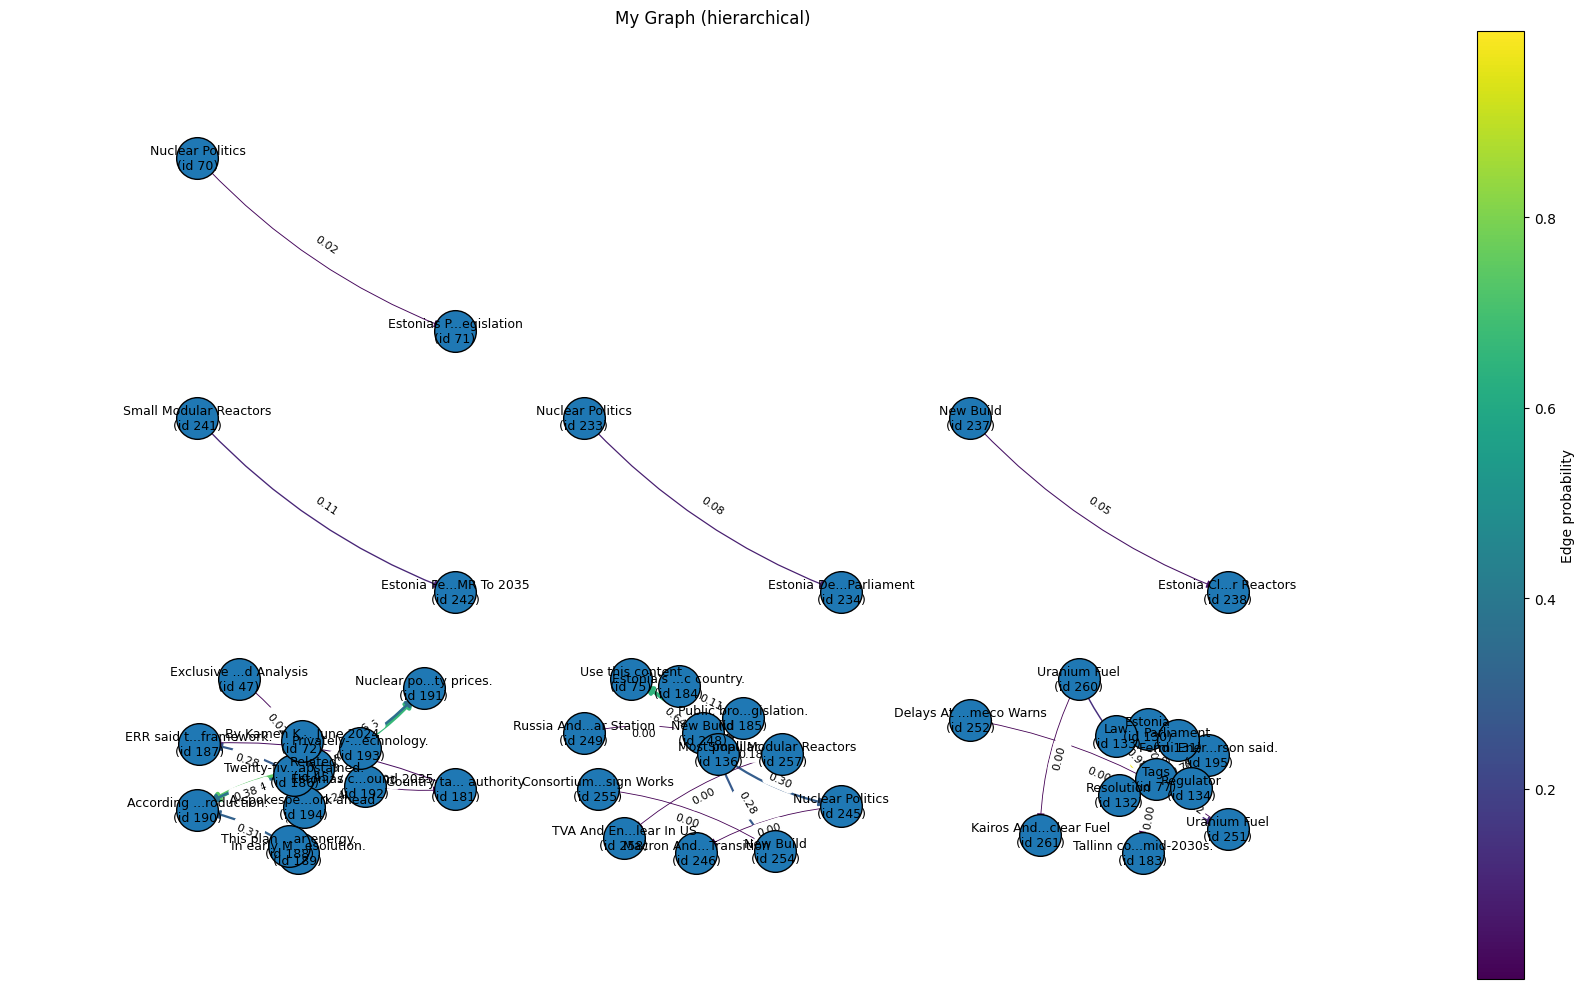

{'G': <networkx.classes.digraph.DiGraph at 0x7e45dde3b1a0>,
 'pos': {192: (np.float64(0.6487141032543833), np.float64(0.3816101917174322)),
  193: (np.float64(0.6323451557617585), np.float64(0.6043777742757181)),
  194: (np.float64(0.4128477682174736), np.float64(0.2614051227006543)),
  72: (np.float64(0.4059296524035373), np.float64(0.6445298780695146)),
  45: (np.float64(0.45051678848938853), np.float64(0.4800076637372093)),
  47: (np.float64(0.15965890213356032), np.float64(1.0)),
  181: (np.float64(1.0), np.float64(0.3667299441338139)),
  186: (np.float64(0.3757399290073084), np.float64(0.44369794510798005)),
  187: (np.float64(0.006783626382995252), np.float64(0.6263983531877126)),
  188: (np.float64(0.35572239091435004), np.float64(0.037880292128141736)),
  189: (np.float64(0.3902282959804637), np.float64(0.0)),
  190: (np.float64(0.0), np.float64(0.24621976710416135)),
  191: (np.float64(0.8777113777984292), np.float64(0.9479638231390125)),
  248: (np.float64(1.9627244432381348)

In [347]:
# Display the graph
textmask = np.array([True]*len(new_txts))
#textmask = filterTextMask(new_txts, "Panavision", False) #& mask = keepTopKMask(txts, 1)

numToShow=len(textmask)
for row in zip(new_edges[textmask][:numToShow], new_xpaths[textmask][:numToShow], new_txts[textmask][:numToShow], new_probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=new_txts[textmask][:numToShow],
    id_edge_pairs=new_edges[textmask][:numToShow],
    xpath_edge_pairs=new_xpaths[textmask][:numToShow],
    probs=new_probs[textmask][:numToShow],
    layout="spring",
    rankdir="LR",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)

['Tags' 'Estonia']
['Estonia' 'Tags']
['Tags' 'Regulator']
['Regulator' 'Tags']
['Tags' 'Law']
['Law' 'Tags']
['Tags' 'Resolution']
['Resolution' 'Tags']
['Tags' 'Parliament']
['Parliament' 'Tags']
['Use this content' 'Most popular']
['Most popular' 'Use this content']
['Use this content' 'Tags']
['Most popular' 'Nuclear Politics']
['Nuclear Politics' 'Most popular']
['Related'
 'According to ERR, supporters of the resolution argue that nuclear power will complement renewable energy sources by providing a stable, continuous generation capacity, thereby reducing the variability in energy production.']
['According to ERR, supporters of the resolution argue that nuclear power will complement renewable energy sources by providing a stable, continuous generation capacity, thereby reducing the variability in energy production.'
 'Related']
['Related' 'By Kamen Kraev 13 June 2024']
['By Kamen Kraev 13 June 2024' 'Related']
['Most popular' 'New Build']
['New Build' 'Most popular']
['Fermi Ener

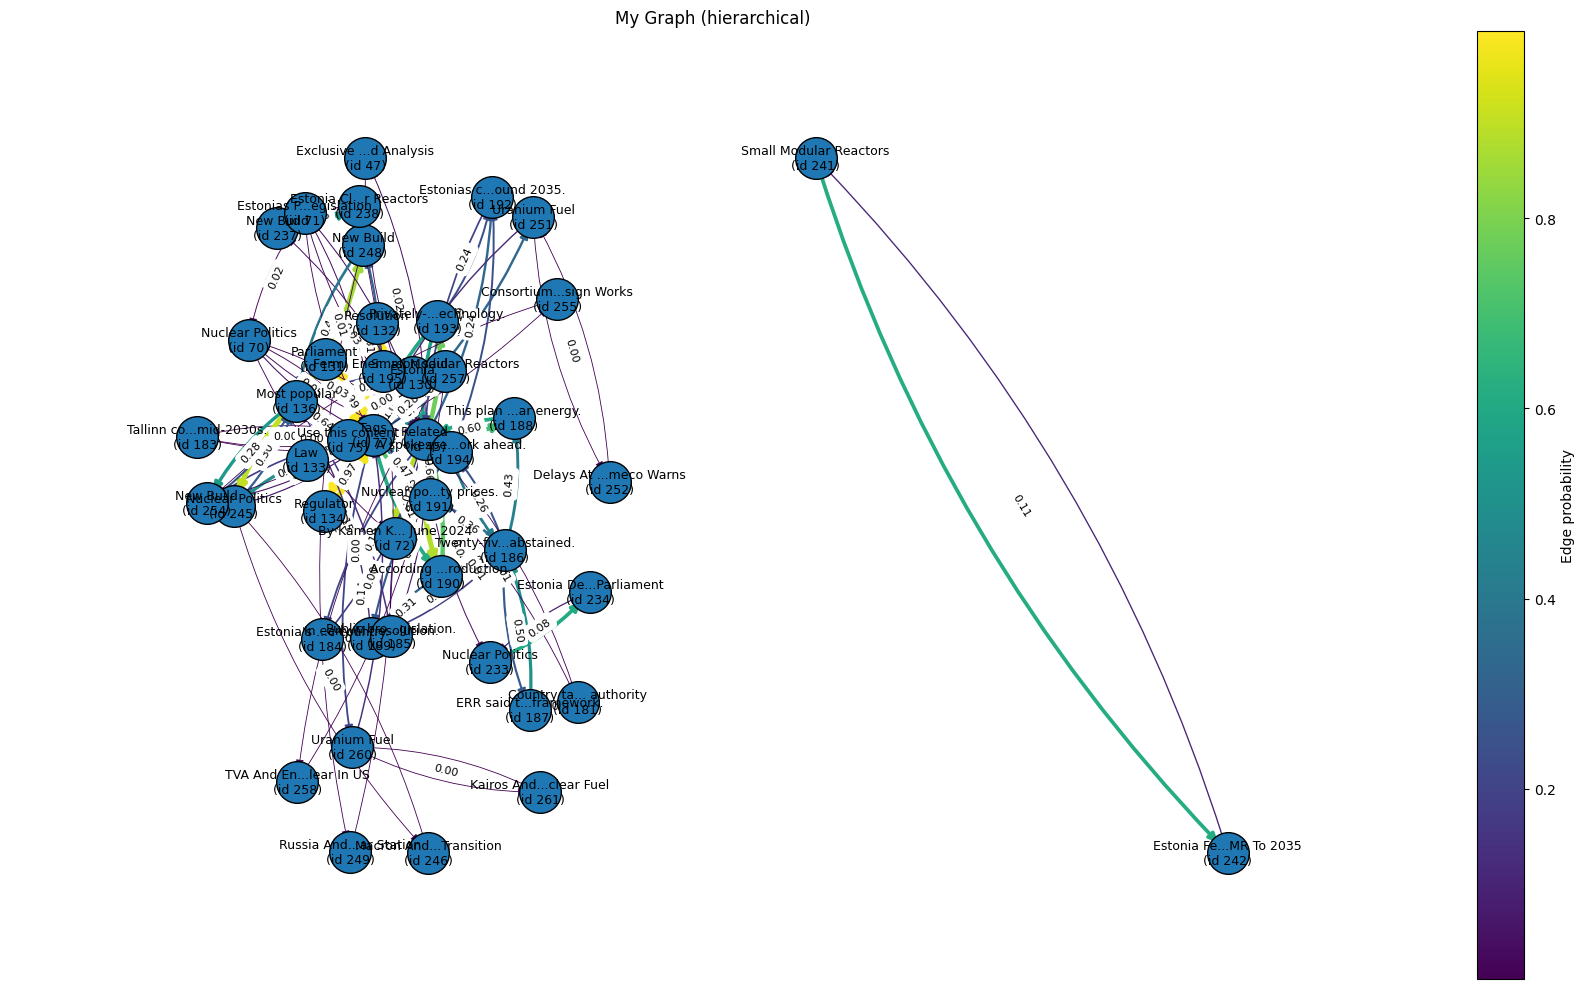

{'G': <networkx.classes.digraph.DiGraph at 0x7e4595b377d0>,
 'pos': {77: (np.float64(0.4252021461907263), np.float64(0.6005395249632071)),
  130: (np.float64(0.5222281351510837), np.float64(0.6850529096806917)),
  134: (np.float64(0.30735972617103335), np.float64(0.4921604524374238)),
  133: (np.float64(0.2648722912814169), np.float64(0.5651698672744897)),
  132: (np.float64(0.4354805634088671), np.float64(0.7621627662161446)),
  131: (np.float64(0.30833931886761207), np.float64(0.7099083446712938)),
  75: (np.float64(0.3650468527988648), np.float64(0.5939143133197844)),
  136: (np.float64(0.2396519937417526), np.float64(0.6496069591384295)),
  245: (np.float64(0.08776602748211382), np.float64(0.49879767717816076)),
  45: (np.float64(0.5523878450146303), np.float64(0.5959335636511871)),
  190: (np.float64(0.5901400240365661), np.float64(0.39829597618484563)),
  72: (np.float64(0.4790026988357024), np.float64(0.4532529931651824)),
  248: (np.float64(0.40166552708085496), np.float64(0.87

In [348]:
# Display the graph
textmask = np.array([True]*len(txts))
#textmask = filterTextMask(new_txts, "Panavision", False) #& mask = keepTopKMask(txts, 1)

numToShow=len(textmask)
for row in zip(sorted_label_index[textmask][:numToShow], xpaths[textmask][:numToShow], txts[textmask][:numToShow], probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=txts[textmask][:numToShow],
    id_edge_pairs=sorted_label_index[textmask][:numToShow],
    xpath_edge_pairs=xpaths[textmask][:numToShow],
    probs=probs[textmask][:numToShow],
    layout="spring",
    rankdir="LR",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)